Let's make an evaluation framework for our deconvolution algorithm

Goals here:
- Generate plots from pure blueprint data
- Generate plots from synthetic mixtures of blueprint data
- Generate plots to evaluate defined mixtures (e.g. healthy data from CyTOF/FACS)
- (Future) generate plots on mixtures of healthy samples
- (Future) inject noise into mixtures

In [3]:
import altair as alt
import pandas as pd
import numpy as np
import scipy.stats as stats
import textwrap
import matplotlib.pyplot as plt
# import seaborn as sns

import torch

/home/semenko/.miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os

In [6]:
# Print the python version and current working path
print("Python version: ", os.sys.version)
print("Current working path: ", os.getcwd())
# Print the current versions of pytorch and altair
print("PyTorch version: ", torch.__version__)
print("Altair version: ", alt.__version__)

# Set the random seed for reproducibility
torch.manual_seed(0)

# Set the number of threads for parallelization
torch.set_num_threads(40)


Python version:  3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:27:40) [GCC 11.3.0]
Current working path:  /home/semenko/liquid-cell-atlas/analysis
PyTorch version:  1.13.1
Altair version:  4.2.2


In [7]:
CELL_TYPES_CYTOF_HIGH_LEVEL = sorted(["T_cells_CD4", "T_cells_CD8", "B_cells", "Monocytes",
                           "NK_cells", "Dendritic_cells", "Plasma_cells"])

CELL_TYPES_CYTOF_LOW_LEVEL = sorted(["T_cells_CD4_naive", "T_cells_CD4_CM", "T_cells_CD4_EM", "T_cells_CD8_naive",
                           "T_cells_CD8_CM", "T_cells_CD8_EMRA", "T_cells_CD8_EM",
                           "T_cells_CD4_Tregs", "B_cells_memory", "B_cells_naive",
                           "Dendritic_cells_mature", "Dendritic_cells_immature"])

CELL_TYPES_CYTOF_ALL = sorted(CELL_TYPES_CYTOF_HIGH_LEVEL + CELL_TYPES_CYTOF_LOW_LEVEL)
CELL_TYPES_CYTOF_ALL

['B_cells',
 'B_cells_memory',
 'B_cells_naive',
 'Dendritic_cells',
 'Dendritic_cells_immature',
 'Dendritic_cells_mature',
 'Monocytes',
 'NK_cells',
 'Plasma_cells',
 'T_cells_CD4',
 'T_cells_CD4_CM',
 'T_cells_CD4_EM',
 'T_cells_CD4_Tregs',
 'T_cells_CD4_naive',
 'T_cells_CD8',
 'T_cells_CD8_CM',
 'T_cells_CD8_EM',
 'T_cells_CD8_EMRA',
 'T_cells_CD8_naive']

First, let's think about what our function will do.

In [8]:

def run_liquid_cell_atlas_bam(input_bam, scoring_matrix, verbose=False):
    """
    Process the bam files to apply LCA scores and return individual cell substate assignments.

    This will run over each line in the bam file, assign a per-fragment score, and return overall
    mixture probabilties based on the scoring_matrix.

    Parameters
    ----------
    input_bam : str
        Path to the bam file to be processed
    scoring_matrix : str
        Path to the scoring matrix to be used for TabNet or whatever

    Returns
    -------
    prob_dict : dict
        Dictionary of cell deconvolution probabilities.
    """
    num_cell_states = len(CELL_TYPES_CYTOF_ALL)
    # The Dirchilet distribution will give us some nice probabilities that sum to ~1
    random_probs = np.random.dirichlet(np.ones(num_cell_states), size=1)[0]

    prob_dict = {}
    # Create a dictionary of cell names and probabilities from random_probs
    for type, prob in zip(CELL_TYPES_CYTOF_ALL, random_probs):
        prob_dict[type] = prob

    if verbose:
        print(prob_dict)

    return prob_dict



In [16]:
results = run_liquid_cell_atlas_bam('test.bam', 'test_matrix.txt', verbose=True)
sum(results.values())

{'B_cells': 0.058345700333757286, 'B_cells_memory': 0.018709383349110223, 'B_cells_naive': 0.00963170338083749, 'Dendritic_cells': 0.05382908782804521, 'Dendritic_cells_immature': 0.01972799438374568, 'Dendritic_cells_mature': 0.004845917190544359, 'Monocytes': 0.009758654980604393, 'NK_cells': 0.06572496023115824, 'Plasma_cells': 0.194341906212277, 'T_cells_CD4': 0.002560523641131563, 'T_cells_CD4_CM': 0.049035395324507056, 'T_cells_CD4_EM': 0.010050787993883375, 'T_cells_CD4_Tregs': 0.028040083486442925, 'T_cells_CD4_naive': 0.2412539795653609, 'T_cells_CD8': 0.025810386236895567, 'T_cells_CD8_CM': 0.12293278314033342, 'T_cells_CD8_EM': 0.012677163685252818, 'T_cells_CD8_EMRA': 0.014226012679364358, 'T_cells_CD8_naive': 0.05849757635674814}


1.0000000000000002

Now that we have a mock, we can build the test framework.

We'll start with "known" true datasets, from Blueprint pre-sorted data, and Healthy mixtures of data.

Evaluating LCA accuracy on CyTOF data for the following 19 cell types:

['B_cells', 'B_cells_memory', 'B_cells_naive', 'Dendritic_cells', 'Dendritic_cells_immature', 'Dendritic_cells_mature',
'Monocytes', 'NK_cells', 'Plasma_cells', 'T_cells_CD4', 'T_cells_CD4_CM', 'T_cells_CD4_EM', 'T_cells_CD4_Tregs',
'T_cells_CD4_naive', 'T_cells_CD8', 'T_cells_CD8_CM', 'T_cells_CD8_EM', 'T_cells_CD8_EMRA', 'T_cells_CD8_naive']
Path: ../data/healthy.csv
Cell type: B_cells
	Correlation coefficient: 0.06706246266510146
Cell type: B_cells_memory
	Correlation coefficient: 0.2792075656552563
Cell type: B_cells_naive
	Correlation coefficient: -0.20305322691794284
Cell type: Dendritic_cells
	Correlation coefficient: -0.28496833963389473
Cell type: Dendritic_cells_immature
	Correlation coefficient: -0.025393939760451185
Cell type: Dendritic_cells_mature
	Correlation coefficient: 0.08809325407885929
Cell type: Monocytes
	Correlation coefficient: -0.1491213803285544
Cell type: NK_cells
	Correlation coefficien

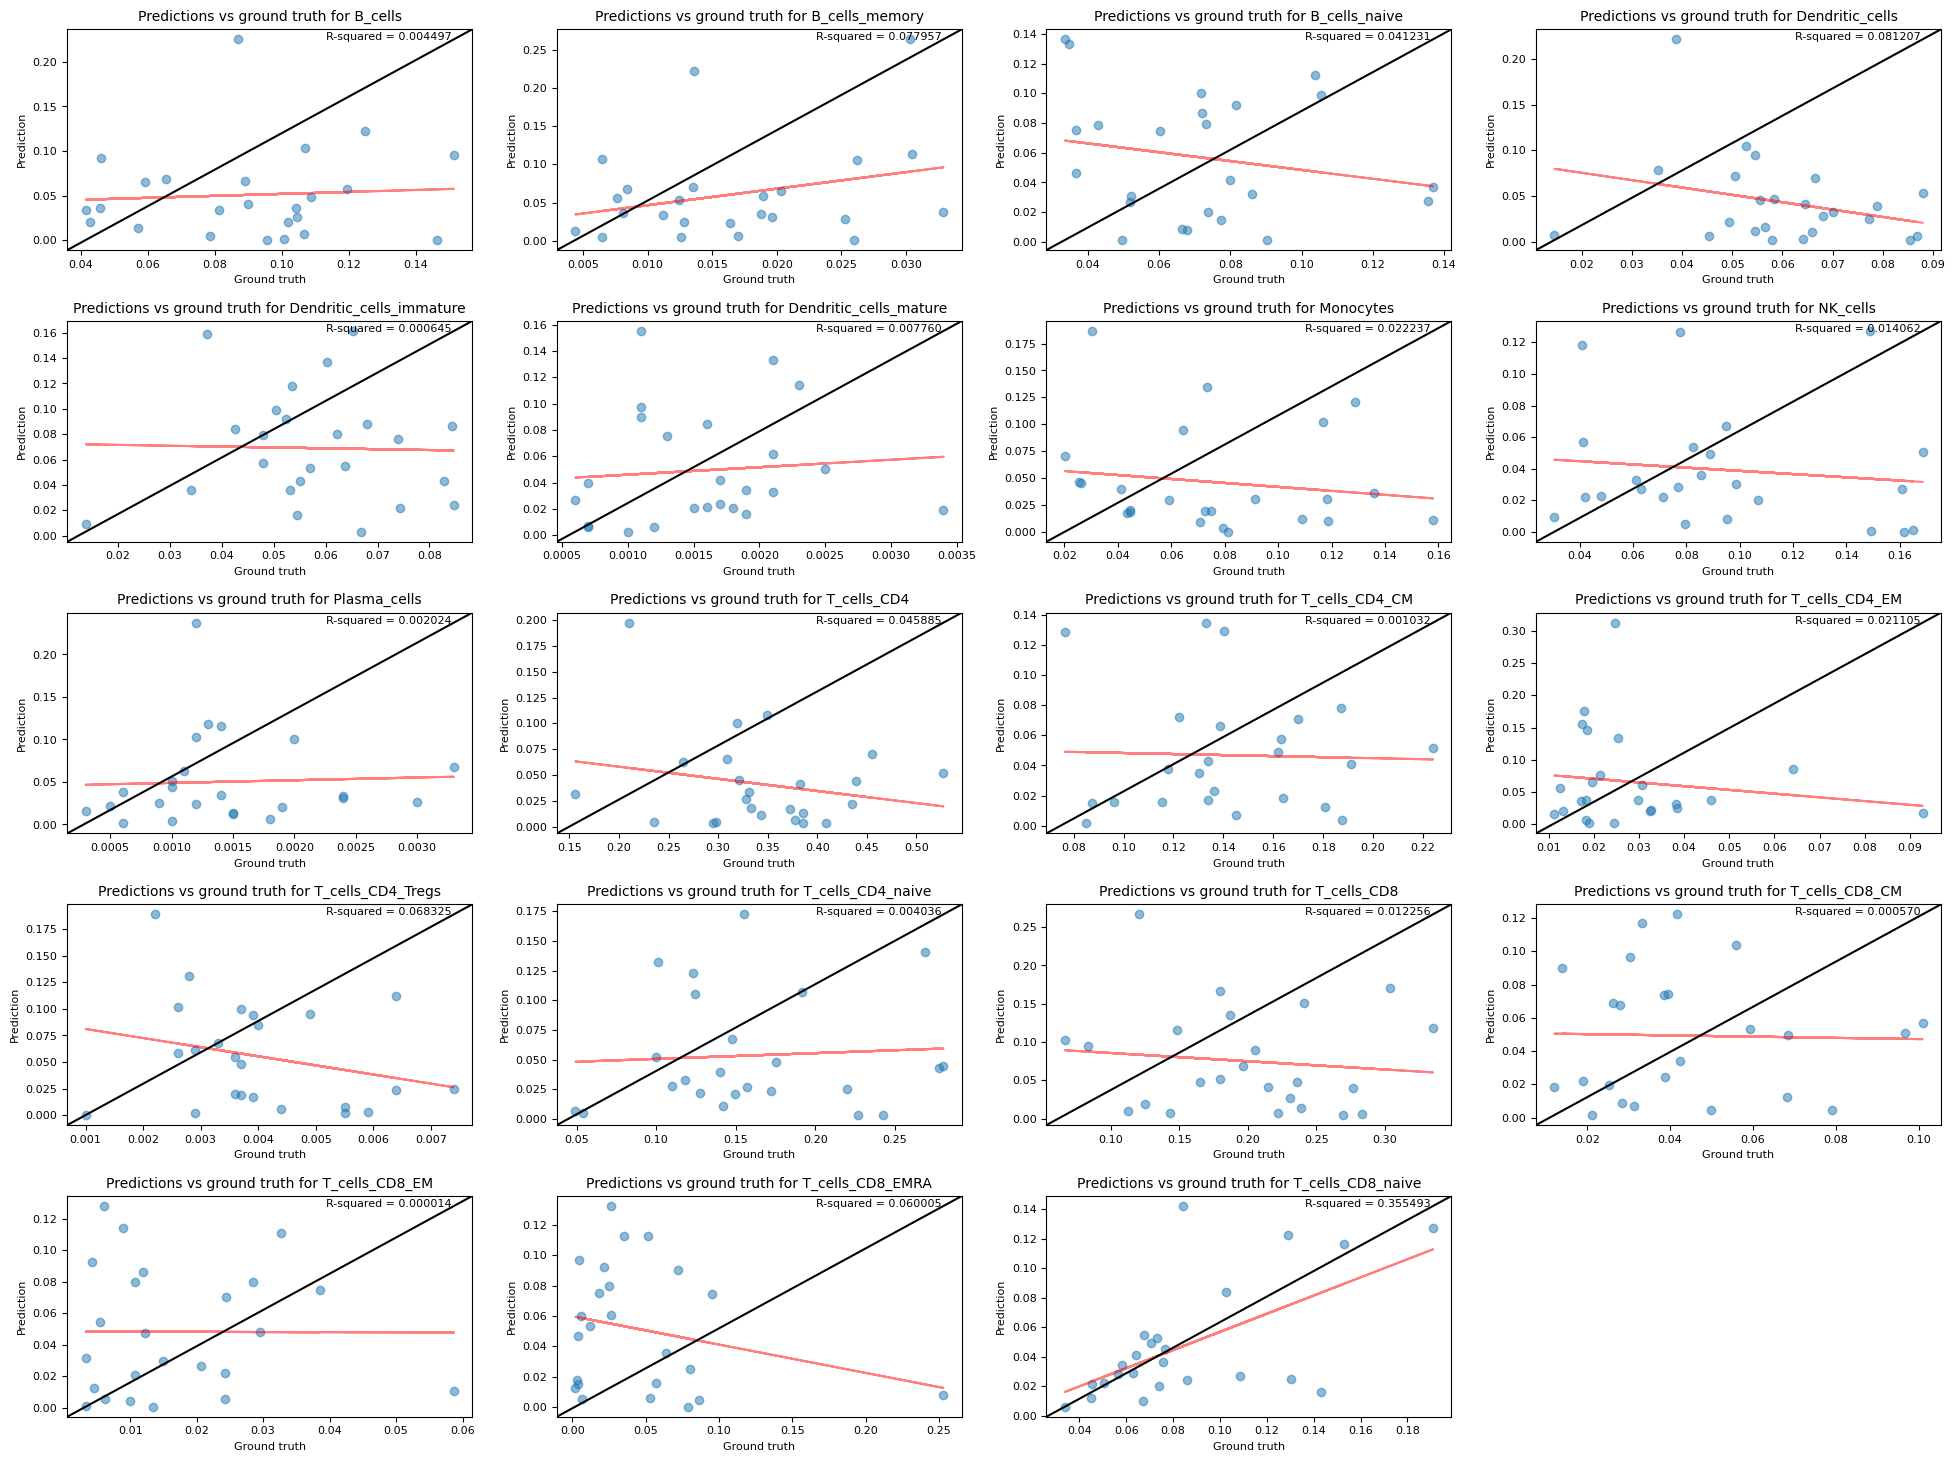

In [49]:
def evaluate_LCA_accuracy_on_healthy(cytof_targets=CELL_TYPES_CYTOF_ALL, facs_targets=False, verbose=True, emseq_only=True):
    """
    Here, we will loop over the healthy samples and evaluate the accuracy of our LCA predictions vs CyTOF.
    """
    if cytof_targets and verbose:
        print(f"Evaluating LCA accuracy on CyTOF data for the following {len(cytof_targets)} cell types:\n")
        print(textwrap.fill(f"{cytof_targets}", 120))

    # TODO: Modularize this from Snakemake -- currently stripped a bit down
    # Load the healthy samples .csv 
    healthy_csv = os.path.join(os.path.dirname("../data/"), "healthy.csv")
    print(f"Path: {healthy_csv}")
    # Load the .csv of our sample data
    healthy_df = pd.read_table(healthy_csv, delimiter=",").set_index("sample_id", drop=False)
    healthy_df["experiment"] = "healthy"

    # If these parameters aren't defined, drop the entry
    healthy_df.dropna(
        subset=[
            "experiment",
            "sample_id",
            "path_R1",
            "path_R2",
            "method",
            "md5sum_R1",
            "md5sum_R2",
        ],
        inplace=True,
    )
    if emseq_only:
        healthy_df = healthy_df[healthy_df["method"] == "emseq"]
    # print(healthy_df.shape)

    ## We've loaded the healthy samples -- let's loop over them and evaluate the accuracy of our LCA predictions

    # For each sample, run run_liquid_cell_atlas_bam and store our predictions in a dictionary
    sample_predictions = {}
    for sample in healthy_df["sample_id"]:
        patient_id = sample.split("_")[2]
        # print(f"Sample: {sample}")
        sample_predictions[patient_id] = run_liquid_cell_atlas_bam('test.bam', 'test_matrix.txt', verbose=False)   

    # Now we have a dictionary of predictions for each sample, and we want to plot versus the known ground truths from CyTOF runs
    # Let's loop over each cell type and plot the predictions vs the ground truth

    # Create a dataframe of the predictions
    predictions_df = pd.DataFrame.from_dict(sample_predictions, orient='index')
    predictions_df.index.name = "sample_id"
    predictions_df.reset_index(inplace=True)
    predictions_df["experiment"] = "healthy"

    # Create a dataframe of the ground truth
    ground_truth_df = pd.read_table("healthy_cytof.csv", delimiter=",")
    ground_truth_df["experiment"] = "healthy"

    # Make a plots directory if it doesn't exist
    if not os.path.exists("../plots"):
        os.makedirs("../plots")

    # print(predictions_df)
    fig, ax2d = plt.subplots(5, 4, figsize=(20, 15))
    # Pad the plots
    fig.tight_layout(pad=3.0)
    flat_axes = ax2d.flatten()

    # Delete any extra axes
    for ax in flat_axes[len(cytof_targets):]:
        fig.delaxes(ax)

    # Loop over each cell type and plot the predictions vs the ground truth
    for count, cell_type in enumerate(cytof_targets):
        print(f"Cell type: {cell_type}")
        # Create a dataframe of the predictions for this cell type
        predictions_df_cell = predictions_df[["sample_id", "experiment", cell_type]]
        predictions_df_cell.columns = ["sample_id", "experiment", "prediction"]
        # print(predictions_df_cell)
        # Create a dataframe of the ground truth for this cell type
        ground_truth_df_cell = ground_truth_df[["sample_id", "experiment", cell_type]]
        ground_truth_df_cell.columns = ["sample_id", "experiment", "ground_truth"]
        # print(ground_truth_df_cell)
        # Merge the two dataframes
        merged_df = pd.merge(predictions_df_cell, ground_truth_df_cell, on=["sample_id", "experiment"], how="inner")
        # print(merged_df)
        # merged_df = merged_df[merged_df["sample_id"].isin(healthy_df["sample_id"])]
        # print(merged_df)

        # Calculate the correlation coefficient
        corr = merged_df["ground_truth"].corr(merged_df["prediction"])
        print(f"\tCorrelation coefficient: {corr}")

        # Axes are modulo the number of rows and columns
        # print(count)
        ax = flat_axes[count]
        # Plot the predictions vs the ground truth with a linear regression line and a 1:1 line
        #fig, ax = plt.subplots()
        ax.scatter(merged_df["ground_truth"], merged_df["prediction"], alpha=0.5)

        # Set our axes limits
        # ax.set_xlim(0, 0.25)
        # ax.set_ylim(0, 0.25)

        ax.set_xlabel("Ground truth")
        ax.set_ylabel("Prediction")
        ax.set_title(f"Predictions vs ground truth for {cell_type}")

        # Add a linear regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df["ground_truth"], merged_df["prediction"])
        # Include the r_value
        ax.text(0.95, 0.95, f"R-squared = {r_value**2:.6f}", transform=ax.transAxes, horizontalalignment='right', fontsize=8)
        line = slope*merged_df["ground_truth"]+intercept
        # Add our line with a label in the upper left
        ax.plot(merged_df["ground_truth"], line, 'r', alpha=0.5, label='linear least-squares fit')
        # ax.legend(loc='upper left')
        # Add a 1:1 line
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black')

        # Make everything smaller
        ax.title.set_fontsize(10)
        ax.xaxis.label.set_fontsize(8)
        ax.yaxis.label.set_fontsize(8)
        ax.tick_params(axis='both', which='major', labelsize=8)
        
        fig.savefig(f"../plots/{cell_type}_predictions_vs_ground_truth_with_regression_and_1_1_line.png")
        # Close our figure
        # plt.close(fig)


evaluate_LCA_accuracy_on_healthy()

In [44]:
# Our goal here is to generate both cell-level plots and overall accuracy plots, from this
# multi-label classification problem.
# We can also generate an ROC curve, confusion matrix, and other metrics.

BLUEPRINT_DEFS = {}

# This is a headache given .beta/.pat formats
GRAIL_DEFS = {}

def evaluate_LCA_accuracy_on_blueprint():
    """
    Evaluate the accuracy of the mixture assignment.

    This will take the mixture assignment and compare it to the ground truth mixture
    assignment to determine the accuracy of the mixture assignment.

    Parameters
    ----------
    None

    Returns
    -------
    None
    """
    # Note blueprint BAMs are not always available -- so we may need to implement at .bw level?
    # NOT the fragment level (!)
    pass


In [ ]:
# 
def generate_cpg_heatmap():
    """
    Helper to generate a heatmap of CpG sites in 
    """
    pass